In [1]:
#numbers and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import sys

#roberta
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import math

# #vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import nltk
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
import string
import re


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Sample news data that was used for our preliminary model testing
import pandas as pd
import glob
import os

%ls /content/drive/MyDrive/Group_project/Code/sample_news
%cd /content/drive/MyDrive/Group_project/Code/sample_news

csv_folder = '/content/drive/MyDrive/Group_project/Code/sample_news/'

pattern = os.path.join(csv_folder, '*.csv')
file_list = glob.glob(pattern)

df_list = []
for fp in file_list:
    df = pd.read_csv(fp)
    source = os.path.basename(fp).replace('.csv','').split('_')[1]
    df['source'] = source
    df_list.append(df)

all_data = pd.concat(df_list, ignore_index=True)

GameStop_BBC.csv  GameStop_CNBC.csv  GameStop_CNN.csv
GameStop_BI.csv   GameStop_CNET.csv  GameStop_VE.csv
/content/drive/.shortcut-targets-by-id/1ouUVa9cO_b84XmO7kdkhqpgoEh4mM3EI/Group project/Code/sample_news


In [4]:
print(all_data.columns)
title_data = all_data[['Title', 'Published']]
body_data = all_data[['Content', 'Published']].copy()
body_data = body_data.dropna()

Index(['Title', 'Link', 'Published', 'Source', 'Content', 'source'], dtype='object')


In [5]:
#VADER
sid = SIA()

#body
body_data['vader sentiments']           = body_data['Content'].astype(str).apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
body_data['vader Positive Sentiment']   = body_data['vader sentiments'].apply(lambda x: x['pos']+1*(10**-6))
body_data['vader Neutral Sentiment']    = body_data['vader sentiments'].apply(lambda x: x['neu']+1*(10**-6))
body_data['vader Negative Sentiment']   = body_data['vader sentiments'].apply(lambda x: x['neg']+1*(10**-6))
body_data['vader Compound Sentiment']   = body_data['vader sentiments'].apply(lambda x: x['compound']+1*(10**-6))
body_data.drop(columns=['vader sentiments'],inplace=True)

In [6]:
#RoBERTa

#connect to GPU
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Using GPU:", torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print("Using CPU")

#model name
#below are the different RoBERTa models we chose to test
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
#MODEL = f"cardiffnlp/twitter-roberta-sentiment-latest"
#MODEL = f"ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)

#function to split chunks if needed since roberta can do 512 at max (max 512 tokens can be processed at a time)
def analyze_large_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=False)  # Encode to token IDs without special tokens
    chunk_size = 512
    # Overlap between chunks to avoid missing context between chunks
    stride = 256
    sentiment_scores = []
    token_lengths = []

    for i in range(0, len(tokens), stride):
        chunk = tokens[i:min(i + chunk_size, len(tokens))]
        chunk_text = tokenizer.decode(chunk)  # Decode back to text

        inputs = tokenizer(chunk_text, return_tensors='pt', truncation=True, max_length=512).to(device)
        output = model(**inputs)
        scores = output[0][0].detach().cpu().numpy()
        scores = softmax(scores)
        sentiment_scores.append(scores)
        token_lengths.append(len(chunk))

    # Weighted average of scores by chunk length
    sentiment_scores = np.array(sentiment_scores)
    weighted_scores = np.average(sentiment_scores, axis=0, weights=token_lengths)

    compound_score = (weighted_scores[2] - weighted_scores[0])

    #decrease the score to 20 ish
    normalised_compound = compound_score / math.sqrt((compound_score*compound_score)+50)

    # Return final aggregated sentiment
    # we want all of this data
    return {
        'roberta_pos': weighted_scores[2], #these are not softmaxed
        'roberta_neu': weighted_scores[1],
        'roberta_neg': weighted_scores[0],
        'roberta_compound': compound_score, #difference between pos and neg
        'roberta_normalised_compound': normalised_compound
    }



#df[['roberta_pos', 'roberta_neu', 'roberta_neg', 'roberta_compound', 'roberta_normalised_compound']] = df['full data'].apply(lambda x: pd.Series(analyze_large_text(x)))
body_data[['roberta_pos', 'roberta_neu', 'roberta_neg', 'roberta_compound', 'roberta_normalised_compound']] = body_data['Content'].apply(lambda x: pd.Series(analyze_large_text(x)))


# print(news_data.columns)

Using GPU: Tesla T4


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [7]:
#Roberta ENSEMBLE MODEL - combines 'Sentiment-Latest' with 'ProsusAI/finbert'

# Device setup (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load both sentiment models
MODEL_1 = "cardiffnlp/twitter-roberta-base-sentiment-latest"  # Social media sentiment model
MODEL_2 = "ProsusAI/finbert"  # Financial sentiment model

tokenizer_1 = AutoTokenizer.from_pretrained(MODEL_1)
model_1 = AutoModelForSequenceClassification.from_pretrained(MODEL_1).to(device)

tokenizer_2 = AutoTokenizer.from_pretrained(MODEL_2)
model_2 = AutoModelForSequenceClassification.from_pretrained(MODEL_2).to(device)

# Function to get sentiment scores for a given model
def get_sentiment_scores(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512).to(device)
    output = model(**inputs)
    scores = output.logits.detach().cpu().numpy()[0]
    return softmax(scores)  # Normalize the scores

# Function to analyse large text chunks
def analyse_large_text_e(text):
    tokens = tokenizer_1.encode(text, add_special_tokens=False)
    chunk_size = 512
    stride = 256
    sentiment_scores_1 = []
    sentiment_scores_2 = []
    token_lengths = []

    for i in range(0, len(tokens), stride):
        chunk = tokens[i:min(i + chunk_size, len(tokens))]
        chunk_text = tokenizer_1.decode(chunk)

        # Get sentiment scores from both models
        scores_1 = get_sentiment_scores(model_1, tokenizer_1, chunk_text)
        scores_2 = get_sentiment_scores(model_2, tokenizer_2, chunk_text)

        sentiment_scores_1.append(scores_1)
        sentiment_scores_2.append(scores_2)
        token_lengths.append(len(chunk))

    # Weighted average of scores (based on token lengths)
    sentiment_scores_1 = np.array(sentiment_scores_1)
    sentiment_scores_2 = np.array(sentiment_scores_2)

    weighted_scores_1 = np.average(sentiment_scores_1, axis=0, weights=token_lengths)
    weighted_scores_2 = np.average(sentiment_scores_2, axis=0, weights=token_lengths)

    compund_score_1 = (weighted_scores_1[2] - weighted_scores_1[0])
    compund_score_2 = (weighted_scores_2[2] - weighted_scores_2[0])

    normalised_compound_1 = compund_score_1 / math.sqrt((compund_score_1*compund_score_1)+15)
    normalised_compound_2 = compund_score_2 / math.sqrt((compund_score_2*compund_score_2)+15)

    avg_compound = (normalised_compound_1 * 3 + normalised_compound_2 * 2) / 5

    compound_score_ensemble = (weighted_scores_1[2] + weighted_scores_2[2] - weighted_scores_1[0] - weighted_scores_2[0])

    normalised_compound = compound_score_ensemble / math.sqrt((compound_score_ensemble*compound_score_ensemble)+35)



    # Return final aggregated sentiment
    # Final ensemble output (Average scores from both models)
    final_scores = (weighted_scores_1 + weighted_scores_2) / 2

    # Return final sentiment scores
    return {
        'ensemble_pos': final_scores[2],  # Positive
        'ensemble_neu': final_scores[1],  # Neutral
        'ensemble_neg': final_scores[0],  # Negative
        'normalised_compound_1': normalised_compound_1,
        'normalised_compound_2': normalised_compound_2,
        'avg_compound': avg_compound,
        'normalised_compound': normalised_compound,
    }

# # Apply sentiment analysis to title and body data
#df[['ensemble_pos', 'ensemble_neu', 'ensemble_neg', 'normalised_compound_1', 'normalised_compound_2','avg_compound', 'normalised_compound']] = all_data['Content'].apply(lambda x: pd.Series(analyse_large_text_e(x)))
# title_data[['ensemble_pos', 'ensemble_neu', 'ensemble_neg']] = title_data['title'].apply(lambda x: pd.Series(analyse_large_text(x)))
body_data[['ensemble_pos', 'ensemble_neu', 'ensemble_neg', 'normalised_compound_1', 'normalised_compound_2','avg_compound', 'normalised_compound']] = body_data['Content'].apply(lambda x: pd.Series(analyse_large_text_e(x)))


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

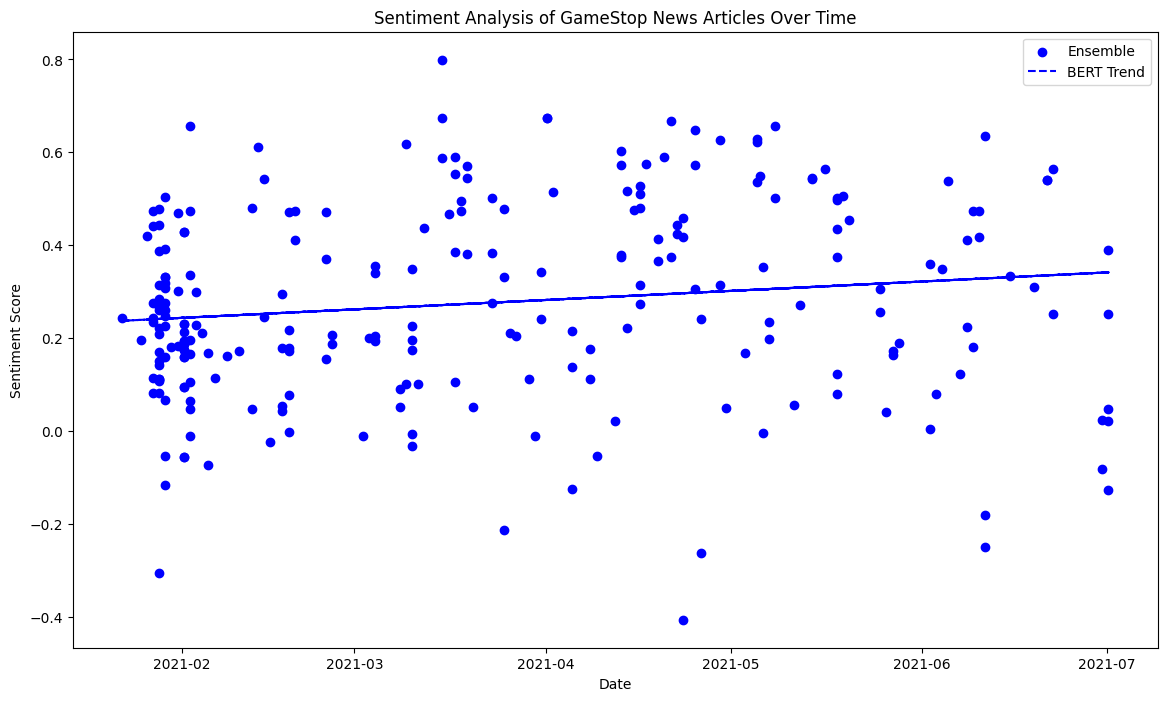

In [8]:
# Convert 'Published' to datetime format and set as index for easier plotting

body_data['Sentiment_Diff_Ensemble'] = body_data['ensemble_pos'] - body_data['ensemble_neg']
# body_data['Sentiment_Diff_Vader'] = body_data['vader Positive Sentiment'] - body_data['vader Negative Sentiment']
# body_data['Sentiment_Diff_BERT'] = body_data['roberta_pos'] - body_data['roberta_neg']


body_data['Published'] = pd.to_datetime(body_data['Published'])
body_data.set_index('Published', drop=False, inplace=True)

# Plot sentiment scores over time for both models
plt.figure(figsize=(14, 8))

# Scatter plots
# plt.scatter(body_data.index, body_data['Sentiment_Diff_BERT'], label='RoBERTa', color='red')
# plt.scatter(body_data.index, body_data['Sentiment_Diff_Vader'], label='VADER', color='blue')
plt.scatter(body_data.index, body_data['Sentiment_Diff_Ensemble'], label='Ensemble', color='blue')

# # Linear regression f
x = body_data.index.map(lambda x: x.toordinal())  # Convert datetime to ordinal for fitting
y = body_data['Sentiment_Diff_Ensemble']
m, b = np.polyfit(x, y, 1)
plt.plot(body_data.index, m * x + b, color='blue', linestyle='--', label='BERT Trend') #change labels accordingly


# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Analysis of GameStop News Articles Over Time')
plt.legend()
plt.show()


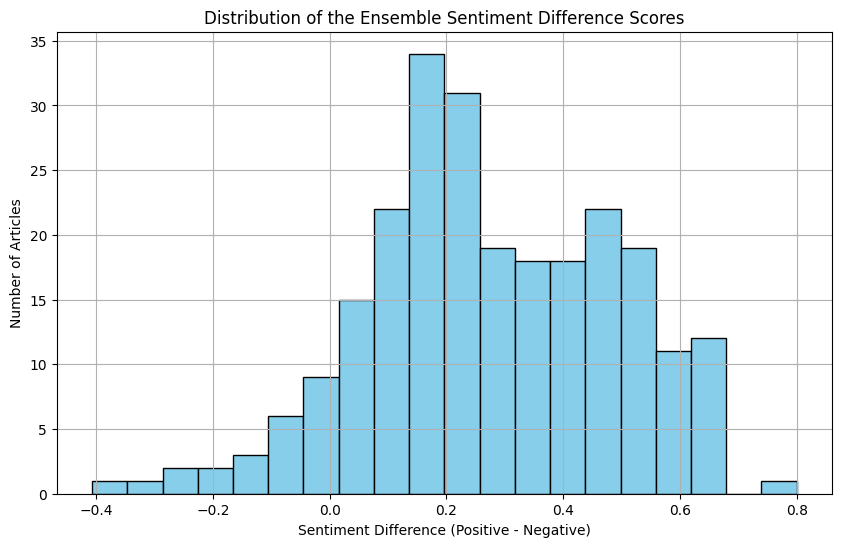

In [12]:
#Creating histograms to visualise the distribution of scores across different models
import matplotlib.pyplot as plt

# Plotting the distribution of Sentiment_Diff_Vader
plt.figure(figsize=(10, 6))
plt.hist(body_data['Sentiment_Diff_Ensemble'], bins=20, edgecolor='black', color='skyblue')

# Styling the plot
plt.title('Distribution of the Ensemble Sentiment Difference Scores')
plt.xlabel('Sentiment Difference (Positive - Negative)')
plt.ylabel('Number of Articles')
plt.grid(True)

# Show plot
plt.show()


The code below shows how we calculate MAE and RMSE scores of each model in comparison to the ground-truths extracted from our user-testing

In [14]:
#MAE and RMSE of model scores
#https://saturncloud.io/blog/how-to-read-data-from-google-sheets-using-colaboratory-google/

import pandas as pd

url = 'https://docs.google.com/spreadsheets/d/1iTP8NtWOMIInWUcqQKfIJcbzzVTLLkJhrlzgjkB86S4/export?format=csv'
df = pd.read_csv(url)
df = df.dropna()


df.head()

# Select the last 5 columns
model_and_truth = df.iloc[:, -5:]

# Split models and ground-truth
model_outputs = model_and_truth.iloc[:, :-1]  # First 4 columns = model outputs
user_avg_scores = model_and_truth.iloc[:, -1] # Last column = average user rating

#Scale data so it makes sense
# Step 1: Rescale model outputs from [-1,1] to [1,5]
model_outputs_scaled = (model_outputs + 1) * 2
model_outputs_scaled = model_outputs_scaled + 1

# Calculate MAE and RMSE
mae_scores = (model_outputs_scaled.sub(user_avg_scores, axis=0)).abs().mean()
rmse_scores = np.sqrt((model_outputs_scaled.sub(user_avg_scores, axis=0) ** 2).mean())

# Combine and display results
error_metrics = pd.DataFrame({
    'MAE': mae_scores,
    'RMSE': rmse_scores
})

print(error_metrics)


             MAE      RMSE
model1  0.517451  0.595099
model2  1.363315  1.586063
model3  0.720605  0.853149
model4  0.712773  0.848213
